In [1]:
import pandas as pd
import tensorflow
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE, RandomOverSampler

from keras.callbacks import ModelCheckpoint

import ast
import nltk

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm
tqdm.pandas()

import pickle

In [2]:
#시드 고정
import random
random.seed(42)
np.random.seed(42)
tensorflow.random.set_seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path= '/content/drive/MyDrive/election/'

## 데이터셋 만들기

In [5]:
social_df = pd.read_csv(path+'merged_Data_final_v3.csv',index_col=0)
social_df = social_df.reset_index()

In [6]:
social_df

,Year,Approval_Rating,CPI,GDP,Employment status,Current_Party,Party_Republican
0,1913,50.000000,9.883333,733625,4.4,0,0
1,1914,50.000000,10.016667,677455,8.0,0,0
2,1915,50.000000,10.108333,695924,9.7,0,0
3,1916,50.000000,10.883333,792425,4.8,0,0
4,1917,50.000000,12.825000,772825,4.8,0,1
...,...,...,...,...,...,...,...
107,2020,41.100000,258.811167,20234100,8.1,1,0
108,2021,41.100000,270.969750,21407700,5.3,0,0
109,2022,41.354119,292.654917,21822000,3.6,0,0
110,2023,40.184738,304.701583,22376900,3.7,0,0


In [7]:
social_x = social_df.drop("Party_Republican",axis=1)
social_y = social_df["Party_Republican"]

combined_4year_x = list()
for i in range(0,social_x.values.shape[0],4):
  combined_4year_x.append(social_x.values[i:i+4])

combined_4year_y = list()
for i in range(0,social_y.values.shape[0],4):
  combined_4year_y.append(social_y.values[i+3])

combined_4year_x = np.array(combined_4year_x)
combined_4year_y = np.array(combined_4year_y)

social_test_x = combined_4year_x[-1:]
social_test_y = combined_4year_y[-1:]


social_train_x = combined_4year_x[:-1]
social_train_y = combined_4year_y[:-1]

from sklearn.model_selection import train_test_split

social_train_x, social_valid_x, social_train_y, social_valid_y = train_test_split(social_train_x, social_train_y, test_size=0.2, random_state=42)

In [8]:
# with open(path+'train_x.pkl','wb') as f:
#   pickle.dump(social_train_x,f)

# with open(path+'train_y.pkl','wb') as f:
#   pickle.dump(social_train_y,f)

# with open(path+'valid_x.pkl','wb') as f:
#   pickle.dump(social_valid_x,f)

# with open(path+'valid_y.pkl','wb') as f:
#   pickle.dump(social_valid_y,f)

# with open(path+'test_x.pkl','wb') as f:
#   pickle.dump(social_test_x,f)

# with open(path+'test_y.pkl','wb') as f:
#   pickle.dump(social_test_y,f)

In [9]:
with open(path+'train_x.pkl','rb') as f:
  social_train_x = pickle.load(f)

with open(path+'train_y.pkl','rb') as f:
  social_train_y = pickle.load(f)

with open(path+'valid_x.pkl','rb') as f:
  social_valid_x = pickle.load(f)

with open(path+'valid_y.pkl','rb') as f:
  social_valid_y = pickle.load(f)

with open(path+'test_x.pkl','rb') as f:
  social_test_x = pickle.load(f)

with open(path+'test_y.pkl','rb') as f:
  social_test_y = pickle.load(f)

In [10]:
text_df = pd.read_csv(path+'text_features.csv', index_col=0)

recent_df = pd.read_csv(path+'2024_text_features.csv', index_col=0)

In [11]:
def add_year(df):
  df["speech_year"] = df["date"].apply(lambda x: x.rstrip()[-4:])
  return

add_year(text_df)
add_year(recent_df)

In [12]:
text_df["speech_year"] = text_df["speech_year"].astype(np.int64)
recent_df["speech_year"] = recent_df["speech_year"].astype(np.int64)

In [13]:
text_df = text_df.drop(["keywords","sentiment","speech_processed"],axis=1)
recent_df = recent_df.drop(["keywords","sentiment","speech_processed"],axis=1)

In [14]:
# text_df.to_csv('text_df.csv')
# recent_df.to_csv('recent_df.csv')

In [15]:
text_df["speech_divide_to_10"] = text_df["speech_processed2"].apply(lambda x: ast.literal_eval(x)).apply(lambda x: [x[i:min(len(x),i+100)] for i in range(0,len(x),100)])
recent_df["speech_divide_to_10"] = recent_df["speech_processed2"].apply(lambda x: ast.literal_eval(x)).apply(lambda x: [x[i:min(len(x),i+100)] for i in range(0,len(x),100)])

In [16]:
merged_text_df = pd.merge(text_df,social_df,how='left',left_on='speech_year', right_on='Year',suffixes=[None,"_y"])
# merged_text_df.to_csv('merged_text_data.csv')

In [17]:
merged_test_df = pd.merge(recent_df,social_df,how='left',left_on='speech_year', right_on='Year',suffixes=[None,"_y"])
# merged_test_df.to_csv('merged_test_data.csv')

In [18]:
# merged_text_df = pd.read_csv('merged_text_data.csv',index_col=0)
# merged_test_df = pd.read_csv('merged_test_data.csv',index_col=0)

In [19]:
merged_text_df["speech_divide_to_10"] = merged_text_df["speech_processed2"].apply(lambda x: ast.literal_eval(x)).apply(lambda x: [x[i:min(len(x),i+100)] for i in range(0,len(x),100)])

In [20]:
len(merged_text_df["speech_divide_to_10"].values[0][0])

100

In [21]:
merged_test_df["speech_divide_to_10"] = merged_test_df["speech_processed2"].apply(lambda x: ast.literal_eval(x)).apply(lambda x: [x[i:min(len(x),i+100)] for i in range(0,len(x),100)])

In [22]:
def name_to_number(name):
  if 'Biden'.lower() in name.lower():
    return 0
  elif 'Trump'.lower() in name.lower():
    return 1
  else:
    return -1
merged_test_df["elected"] = merged_test_df["name"].apply(name_to_number)

In [23]:
train_df, valid_df = train_test_split(merged_text_df, test_size=0.2, random_state=42)
# train_df.to_csv(path+'train_data.csv')
# valid_df.to_csv(path+'valid_data.csv')
# merged_test_df.to_csv(path+'test_data.csv')


In [24]:
test_df = merged_test_df

In [25]:
# train_df = pd.read_csv('train_data.csv',index_col=0)
# valid_df = pd.read_csv('valid_data.csv',index_col=0)
# test_df = pd.read_csv('test_data.csv',index_col=0)

In [26]:
# train_df.to_csv('train_data.csv')
# valid_df.to_csv('valid_data.csv')
# test_df.to_csv('test_data.csv')

## 주제별 Importance 사용한 예측 모델

In [27]:
importance_columns = ['Year', 'environment_importance',
       'economy_importance', 'diplomacy_importance', 'immigration_importance',
       'justice_importance', 'education_importance', 'Healthcare_importance',
       'military_importance', 'ideal_importance', 'elected']

train_importance_df, valid_importance_df = train_test_split(text_df[importance_columns], test_size=0.2, random_state=42)


# train_importance_df = train_df[['Year', 'environment_importance',
#        'economy_importance', 'diplomacy_importance', 'immigration_importance',
#        'justice_importance', 'education_importance', 'Healthcare_importance',
#        'military_importance', 'ideal_importance', 'elected']]

# valid_importance_df = valid_df[['Year', 'environment_importance',
#        'economy_importance', 'diplomacy_importance', 'immigration_importance',
#        'justice_importance', 'education_importance', 'Healthcare_importance',
#        'military_importance', 'ideal_importance', 'elected']]

test_importance_df = recent_df[importance_columns]

In [28]:
# train_importance_df.to_csv(path+'train_importance_data.csv')
# valid_importance_df.to_csv(path+'valid_importance_data.csv')
# test_importance_df.to_csv(path+'test_importance_data.csv')


In [29]:
importance_train_x_df = train_importance_df.drop('elected',axis=1)
importance_train_y_df = train_importance_df['elected']

importance_valid_x_df = valid_importance_df.drop('elected',axis=1)
importance_valid_y_df = valid_importance_df['elected']

importance_test_x_df = test_importance_df.drop('elected',axis=1)
importance_test_y_df = test_importance_df['elected']

In [30]:
importance_scaler = MinMaxScaler()
importance_train_x = importance_scaler.fit_transform(importance_train_x_df)
importance_valid_x = importance_scaler.transform(importance_valid_x_df)

importance_test_x = importance_scaler.transform(importance_test_x_df)

importance_train_y = np.array(importance_train_y_df)
importance_valid_y = np.array(importance_valid_y_df)
importance_test_y = np.array(importance_test_y_df)

In [31]:
#hyperparameters

lr = 1e-3
dropout_p = 0.5
num_epochs = 200

In [32]:
def get_importance_model(num_features,hidden_layers=[64]):
  input = keras.layers.Input(num_features)
  x = keras.layers.Dense(128,activation='relu')(input)
  x = keras.layers.Dropout(dropout_p)(x)
  # x = keras.layers.Dense(64,activation='relu')(input)
  if hidden_layers:
    for layer in hidden_layers:
      x = keras.layers.Dense(layer, activation='relu')(x)
  # x = keras.layers.Dropout(dropout_p)
  output = keras.layers.Dense(1,activation='sigmoid')(x)

  return keras.Model(input,output)

In [33]:
importance_model = get_importance_model(10)
importance_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
importance_extractor =  keras.Model(importance_model.input, importance_model.layers[-2].output)

In [35]:
def compile(model,optimizer='adam',loss='binary_crosentropy'):
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return

compile(importance_model,optimizer=keras.optimizers.Adam(learning_rate=lr))

def run(model, train_x, train_y, valid_x=None, valid_y=None, path='./best_model.h5', epoch_num=10):
  checkpoint = ModelCheckpoint(filepath=path, save_weights_only=True, monitor='val_accuracy', save_best_only=True)
  if valid_x is not None and valid_y is not None:
    hist = model.fit(train_x, train_y, epochs=epoch_num, validation_data=(valid_x,valid_y), callbacks=[checkpoint])
  else:
    hist = model.fit(train_x, train_y, epochs=epoch_num)
  return hist


importance_hist = run(importance_model, importance_train_x, importance_train_y, importance_valid_x, importance_valid_y, path='best_importance.h5', epoch_num=num_epochs)

Epoch 1/200
85/85 [==============================] - 4s 8ms/step - loss: 0.6789 - accuracy: 0.5893 - val_loss: 0.6693 - val_accuracy: 0.6059
Epoch 2/200
85/85 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.5951 - val_loss: 0.6608 - val_accuracy: 0.6059
Epoch 3/200
85/85 [==============================] - 0s 4ms/step - loss: 0.6669 - accuracy: 0.5966 - val_loss: 0.6592 - val_accuracy: 0.6206
Epoch 4/200
85/85 [==============================] - 0s 4ms/step - loss: 0.6614 - accuracy: 0.5974 - val_loss: 0.6533 - val_accuracy: 0.6162
Epoch 5/200
85/85 [==============================] - 0s 5ms/step - loss: 0.6600 - accuracy: 0.5904 - val_loss: 0.6526 - val_accuracy: 0.6162
Epoch 6/200
85/85 [==============================] - 1s 6ms/step - loss: 0.6573 - accuracy: 0.6032 - val_loss: 0.6514 - val_accuracy: 0.6279
Epoch 7/200
85/85 [==============================] - 0s 5ms/step - loss: 0.6592 - accuracy: 0.5933 - val_loss: 0.6487 - val_accuracy: 0.6147
Epoch 8/200
8

In [36]:
# importance_model.predict(importance_test_x)

In [37]:
# importance_model.evaluate(importance_test_x,importance_test_y)

In [38]:
# from sklearn.metrics import confusion_matrix

# #Predict
# y_prediction = importance_model.predict(test_x)

# #Create confusion matrix and normalizes it over predicted (columns)
# result = confusion_matrix(test_y, np.rint(y_prediction))

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# disp = ConfusionMatrixDisplay(confusion_matrix=result,
#                               display_labels=[0,1])

# disp.plot()
# plt.show()

## 텍스트 사용 모델

In [39]:
text_columns = ["speech_divide_to_10","elected"]

train_text_df, valid_text_df = train_test_split(text_df[text_columns], test_size=0.2, random_state=42)
test_text_df = recent_df[text_columns]

In [40]:
def sections_to_data(df):
  data = list()
  for row in df.values:
    for section in row[0]:
      data.append({"section": section, "elected": row[1]})
  # print(data)
  return pd.DataFrame(data)



In [41]:
train_text_df = sections_to_data(train_text_df)
valid_text_df = sections_to_data(valid_text_df)
test_text_df = sections_to_data(test_text_df)

train_text_x_df = train_text_df["section"]
valid_text_x_df = valid_text_df["section"]
test_text_x_df = test_text_df["section"]

train_text_y_df = train_text_df["elected"]
valid_text_y_df = valid_text_df["elected"]
test_text_y_df = test_text_df["elected"]



In [42]:
train_text_df.to_csv(path+'train_text_data.csv')
valid_text_df.to_csv(path+'valid_text_data.csv')
test_text_df.to_csv(path+'test_text_data.csv')

In [43]:
text_train_y = np.array(train_text_y_df)
text_valid_y = np.array(valid_text_y_df)
text_test_y = np.array(test_text_y_df)

In [44]:
result = list()
for lst in train_text_x_df.values:
  result+=lst
result = set(result)

len(result)

39143

In [45]:
# train set엔 기본적으로 39143개
max_vocab_size = 40000

tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(train_text_x_df)

train_sequences = tokenizer.texts_to_sequences(train_text_x_df)
valid_sequences = tokenizer.texts_to_sequences(valid_text_x_df)
test_sequences = tokenizer.texts_to_sequences(test_text_x_df)

train_padded_sequences = pad_sequences(train_sequences, maxlen=100)
valid_padded_sequences = pad_sequences(valid_sequences, maxlen=100)
test_padded_sequences = pad_sequences(test_sequences, maxlen=100)

In [46]:
def get_text_model(timestep, hidden_layers=None):
  input = keras.layers.Input(shape=(timestep,))
  x = keras.layers.Embedding(max_vocab_size, 128, input_length=100)(input)
  x = keras.layers.LSTM(64)(x)
  if hidden_layers:
    for layer in hidden_layers:
      x = keras.layers.Dense(layer, activation='relu')(x)
  output = keras.layers.Dense(1, activation='sigmoid')(x)
  return keras.Model(input, output)

In [47]:
text_model = get_text_model(100)
text_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 128)          5120000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5169473 (19.72 MB)
Trainable params: 5169473 (19.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
text_extractor = keras.Model(text_model.input, text_model.layers[-2].output)

In [49]:
text_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [50]:
num_epochs = 20


def run(model, train_x, train_y, valid_x=None, valid_y=None, path='./best_model.h5', epoch_num=10):
  checkpoint = ModelCheckpoint(filepath=path, save_weights_only=True, monitor='val_accuracy', save_best_only=True)
  if valid_x is not None and valid_y is not None:
    hist = model.fit(train_x, train_y, epochs=epoch_num, validation_data=(valid_x,valid_y), callbacks=[checkpoint])
  else:
    hist = model.fit(train_x, train_y, epochs=epoch_num)
  return hist

text_hist = run(text_model, train_padded_sequences, text_train_y, valid_padded_sequences,text_valid_y, path='best_text.h5', epoch_num=num_epochs)

Epoch 1/20
834/834 [==============================] - 37s 41ms/step - loss: 0.4219 - accuracy: 0.8015 - val_loss: 0.3852 - val_accuracy: 0.8346
Epoch 2/20
834/834 [==============================] - 12s 15ms/step - loss: 0.2020 - accuracy: 0.9224 - val_loss: 0.3986 - val_accuracy: 0.8285
Epoch 3/20
834/834 [==============================] - 11s 13ms/step - loss: 0.1118 - accuracy: 0.9593 - val_loss: 0.4674 - val_accuracy: 0.8260
Epoch 4/20
834/834 [==============================] - 9s 11ms/step - loss: 0.0669 - accuracy: 0.9766 - val_loss: 0.8444 - val_accuracy: 0.8198
Epoch 5/20
834/834 [==============================] - 8s 9ms/step - loss: 0.0421 - accuracy: 0.9855 - val_loss: 0.8088 - val_accuracy: 0.8279
Epoch 6/20
834/834 [==============================] - 9s 11ms/step - loss: 0.0302 - accuracy: 0.9899 - val_loss: 0.8963 - val_accuracy: 0.8149
Epoch 7/20
834/834 [==============================] - 8s 9ms/step - loss: 0.0275 - accuracy: 0.9908 - val_loss: 0.8527 - val_accuracy: 0.827

## 사회적 지표 사용 모델

In [83]:
ind = ''
with open(path+ind+'train_x.pkl','rb') as f:
  social_train_x = pickle.load(f)

with open(path+ind+'train_y.pkl','rb') as f:
  social_train_y = pickle.load(f)

with open(path+ind+'valid_x.pkl','rb') as f:
  social_valid_x = pickle.load(f)

with open(path+ind+'valid_y.pkl','rb') as f:
  social_valid_y = pickle.load(f)

with open(path+ind+'test_x.pkl','rb') as f:
  social_test_x = pickle.load(f)

with open(path+ind+'test_y.pkl','rb') as f:
  social_test_y = pickle.load(f)

In [84]:
social_train_x = social_train_x[:,:,1:]
social_valid_x = social_valid_x[:,:,1:]
social_test_x = social_test_x[:,:,1:]

In [85]:
social_train_x.shape

(21, 4, 5)

In [86]:
social_scaler = MinMaxScaler()
social_train_x = social_scaler.fit_transform(social_train_x.reshape(-1, social_train_x.shape[-1])).reshape(social_train_x.shape)
social_valid_x = social_scaler.transform(social_valid_x.reshape(-1, social_valid_x.shape[-1])).reshape(social_valid_x.shape)
social_test_x = social_scaler.transform(social_test_x.reshape(-1, social_test_x.shape[-1])).reshape(social_test_x.shape)

In [87]:
input_feature = 5  # 고정
dropout_p = 0.5
num_epochs = 50
lr = 1e-4
kernel_size = 4

In [88]:
def get_lstm_model(input_features, dropout_p, dense_layers=None):
    input = keras.layers.Input(shape=(4, input_features))
    x = keras.layers.LSTM(64, dropout=dropout_p)(input)
    if dense_layers:
        for i in dense_layers:
            x = keras.layers.Dense(i, activation='relu')(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(input, output)
    return model

def get_cnn_model(input_features, dropout_p, kernel_size, dense_layers=[64]):
    input = keras.layers.Input(shape=(4, input_features))
    x = keras.layers.Conv1D(filters=32, kernel_size=kernel_size, activation='relu')(input)
    x = keras.layers.Dropout(dropout_p)(x)
    if dense_layers:
        for i in dense_layers:
            x = keras.layers.Dense(i, activation='relu')(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)[:,:,0]
    model = keras.Model(input, output)
    return model

In [89]:
def compile_social_model(model,optimizer='adam',loss='binary_crosentropy'):
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return

def run_social_model(model, train_x, train_y, valid_x=None, valid_y=None, path='./best_social.h5', epoch_num=10):
  checkpoint = ModelCheckpoint(filepath=path, save_weights_only=True, monitor='val_accuracy', save_best_only=True)
  if valid_x is not None and valid_y is not None:
    hist = model.fit(train_x, train_y, epochs=epoch_num, validation_data=(valid_x, valid_y), callbacks=[checkpoint])
  else:
    hist = model.fit(train_x, train_y, epochs=epoch_num)
  return hist

In [90]:
social_model = get_cnn_model(input_feature, dropout_p, kernel_size)
social_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4, 5)]            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 32)             672       
                                                                 
 dropout_3 (Dropout)         (None, 1, 32)             0         
                                                                 
 dense_8 (Dense)             (None, 1, 64)             2112      
                                                                 
 dense_9 (Dense)             (None, 1, 1)              65        
                                                                 
 tf.__operators__.getitem_2  (None, 1)                 0         
  (SlicingOpLambda)                                              
                                                           

In [91]:
social_extractor = keras.Model(social_model.input, social_model.layers[-3].output)

In [92]:
compile_social_model(social_model,optimizer=keras.optimizers.Adam(learning_rate=lr))

In [93]:
social_hist = run_social_model(social_model, social_train_x, social_train_y, valid_x = social_valid_x, valid_y=social_valid_y, path='best_social.h5', epoch_num=num_epochs)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.6844 - accuracy: 0.5714 - val_loss: 0.7089 - val_accuracy: 0.3333
Epoch 2/50
1/1 [==============================] - 0s 35ms/step - loss: 0.6963 - accuracy: 0.3810 - val_loss: 0.7090 - val_accuracy: 0.3333
Epoch 3/50
1/1 [==============================] - 0s 30ms/step - loss: 0.7040 - accuracy: 0.5238 - val_loss: 0.7090 - val_accuracy: 0.3333
Epoch 4/50
1/1 [==============================] - 0s 30ms/step - loss: 0.7024 - accuracy: 0.4286 - val_loss: 0.7090 - val_accuracy: 0.3333
Epoch 5/50
1/1 [==============================] - 0s 30ms/step - loss: 0.6848 - accuracy: 0.6190 - val_loss: 0.7091 - val_accuracy: 0.3333
Epoch 6/50
1/1 [==============================] - 0s 34ms/step - loss: 0.6861 - accuracy: 0.4762 - val_loss: 0.7091 - val_accuracy: 0.3333
Epoch 7/50
1/1 [==============================] - 0s 31ms/step - loss: 0.6756 - accuracy: 0.6190 - val_loss: 0.7092 - val_accuracy: 0.3333
Epoch 8/50
1/1 [=============

In [94]:
social_model.predict(social_test_x)

1/1 [==============================] - 0s 163ms/step


array([[0.4012885]], dtype=float32)

## Combined Model

In [95]:
def sections_to_data(df):
  column_to_move = df.pop("speech_divide_to_10")
  df.insert(0, "speech_divide_to_10", column_to_move)

  data = list()
  for row in df.values:
    for section in row[0]:
      data_dict = {"section": section}
      for i in range(1,len(row)):
        data_dict[df.columns[i]] = row[i]
      data.append(data_dict)
  # print(data)
  return pd.DataFrame(data)



In [96]:
train_df = sections_to_data(train_df)
valid_df = sections_to_data(valid_df)
test_df = sections_to_data(test_df)

KeyError: 'speech_divide_to_10'

In [ ]:
# train set엔 기본적으로 959개
# max_vocab_size = 40000

# tokenizer = Tokenizer(num_words = max_vocab_size)
# tokenizer.fit_on_texts(train_df["section"])

train_df["section_sequence"] = train_df["section"].apply(tokenizer.texts_to_sequences)
valid_df["section_sequence"] = valid_df["section"].apply(tokenizer.texts_to_sequences)#.apply(lambda x: pad_sequences([elem for lst in x for elem in lst], maxlen=100))
test_df["section_sequence"] = test_df["section"].apply(tokenizer.texts_to_sequences)#.apply(lambda x: pad_sequences([elem for lst in x for elem in lst], maxlen=100))

train_df["section_sequence"] = train_df["section_sequence"].apply(lambda x: [elem for lst in x for elem in lst])
valid_df["section_sequence"] = valid_df["section_sequence"].apply(lambda x: [elem for lst in x for elem in lst])
test_df["section_sequence"] = test_df["section_sequence"].apply(lambda x: [elem for lst in x for elem in lst])



# train_sequences = tokenizer.texts_to_sequences(train_x_df["section"])
# valid_sequences = tokenizer.texts_to_sequences(train_x_df["section"])
# test_sequences = tokenizer.texts_to_sequences(train_x_df["section"])

# train_padded_sequences = pad_sequences(train_sequences, maxlen=100)
# valid_padded_sequences = pad_sequences(valid_sequences, maxlen=100)
# test_padded_sequences = pad_sequences(test_sequences, maxlen=100)

In [ ]:
train_df["section_sequence"] = train_df["section_sequence"].apply(lambda x: pad_sequences([x],maxlen=100)[0])
valid_df["section_sequence"] = valid_df["section_sequence"].apply(lambda x: pad_sequences([x],maxlen=100)[0])
test_df["section_sequence"] = test_df["section_sequence"].apply(lambda x: pad_sequences([x],maxlen=100)[0])

In [ ]:
# train_df.to_csv('train_data_w_seq.csv')
# valid_df.to_csv('valid_data_w_seq.csv')
# test_df.to_csv('test_data_w_seq.csv')

In [ ]:
# importance_scaler = MinMaxScaler()
importance_columns = ['Year', 'environment_importance',
       'economy_importance', 'diplomacy_importance', 'immigration_importance',
       'justice_importance', 'education_importance', 'Healthcare_importance',
       'military_importance', 'ideal_importance']

# train_importance = importance_scaler.fit_transform(train_df[importance_columns])

train_df[importance_columns] = importance_scaler.transform(train_df[importance_columns])
valid_df[importance_columns] = importance_scaler.transform(valid_df[importance_columns])
test_df[importance_columns] = importance_scaler.transform(test_df[importance_columns])
# valid_x = importance_scaler.transform(valid_x_df)

# test_x = importance_scaler.transform(test_x_df)

# train_y = np.array(train_y_df)
# valid_y = np.array(valid_y_df)
# test_y = np.array(test_y_df)

In [ ]:
train_df

In [98]:
social_columns = ['Approval_Rating', 'CPI', 'GDP', 'Employment status',
       'Current_Party']

train_df[social_columns] = social_scaler.transform(train_df[social_columns])
valid_df[social_columns] = social_scaler.transform(valid_df[social_columns])
test_df[social_columns] = social_scaler.transform(test_df[social_columns])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [99]:
def get_4year(year):
  data = combined_4year_x[(year - 1913)//4][:,1:]
  data = social_scaler.transform(data.reshape(-1,data.shape[-1])).reshape(data.shape)
  return data

train_df["4year"] = train_df["speech_year"].apply(get_4year)
valid_df["4year"] = valid_df["speech_year"].apply(get_4year)
test_df["4year"] = test_df["speech_year"].apply(get_4year)

In [100]:
social_model.load_weights('best_social.h5')
text_model.load_weights('best_text.h5')
importance_model.load_weights('best_importance.h5')

In [101]:
social_input = keras.Input(shape=(4,5))
importance_input = keras.Input(shape=(10,))
text_input = keras.Input(shape=(100,))

social_logit = social_extractor(social_input)
importance_logit = importance_extractor(importance_input)
text_logit = text_extractor(text_input)

social_output = social_model(social_input)
importance_output = importance_model(importance_input)
text_output = text_model(text_input)

combined_logit = keras.layers.concatenate([social_logit[:,0,:], importance_logit, text_logit])
# combined_logit = keras.layers.concatenate([importance_logit, text_logit])

ensemble_output = keras.layers.Dense(1, activation='sigmoid')(combined_logit)

combined_model = keras.Model(inputs=[social_input, importance_input, text_input], outputs=ensemble_output)
# combined_model = keras.Model(inputs=[importance_input, text_input], outputs=ensemble_output)

In [ ]:
# train_df.to_csv(path+'train_data_f.csv')
# valid_df.to_csv(path+'valid_data_f.csv')
# test_df.to_csv(path+'test_data_f.csv')

In [102]:
# combined_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

combined_importance_x_train = train_df[importance_columns].to_numpy()
combined_importance_x_train = np.stack(combined_importance_x_train)
combined_text_x_train = train_df["section_sequence"].to_numpy()
combined_text_x_train = np.stack(combined_text_x_train)
combined_social_x_train = train_df["4year"].to_numpy()
combined_social_x_train = np.stack(combined_social_x_train)

combined_importance_x_valid = valid_df[importance_columns].to_numpy()
combined_importance_x_valid = np.stack(combined_importance_x_valid)
combined_text_x_valid = valid_df["section_sequence"].to_numpy()
combined_text_x_valid = np.stack(combined_text_x_valid)
combined_social_x_valid = valid_df["4year"].to_numpy()
combined_social_x_valid = np.stack(combined_social_x_valid)

combined_importance_x_test = test_df[importance_columns].to_numpy()
combined_importance_x_test = np.stack(combined_importance_x_test)
combined_text_x_test = test_df["section_sequence"].to_numpy()
combined_text_x_test = np.stack(combined_text_x_test)
combined_social_x_test = test_df["4year"].to_numpy()
combined_social_x_test = np.stack(combined_social_x_test)


def run(model, train_x, train_y, valid_x=None, valid_y=None, path='./best_model.h5', epoch_num=10):
  checkpoint = ModelCheckpoint(filepath=path, save_weights_only=True, monitor='val_accuracy', save_best_only=True)
  if valid_x is not None and valid_y is not None:
    hist = model.fit(train_x, train_y, epochs=epoch_num, validation_data=(valid_x,valid_y), callbacks=[checkpoint])
  else:
    hist = model.fit(train_x, train_y, epochs=epoch_num)
  return hist


combined_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

combined_hist = run(combined_model, [combined_social_x_train, combined_importance_x_train, combined_text_x_train], train_df["elected"].values, [combined_social_x_valid, combined_importance_x_valid, combined_text_x_valid],valid_df["elected"].values, path='best_combined.h5', epoch_num=20)

# combined_model.fit([importance_x, text_x], train_df["elected"], epochs=20)
# combined_hist = combined_model.fit([combined_social_x_train, combined_importance_x_train, combined_text_x_train], train_df["elected"].values, validation_data = ([combined_social_x_valid, combined_importance_x_valid, combined_text_x_valid], valid_df["elected"].values), epochs=20)

Epoch 1/20
834/834 [==============================] - 40s 44ms/step - loss: 0.2155 - accuracy: 0.9192 - val_loss: 0.4620 - val_accuracy: 0.8426
Epoch 2/20
834/834 [==============================] - 12s 15ms/step - loss: 0.1138 - accuracy: 0.9586 - val_loss: 0.4511 - val_accuracy: 0.8415
Epoch 3/20
834/834 [==============================] - 12s 15ms/step - loss: 0.0680 - accuracy: 0.9763 - val_loss: 0.5376 - val_accuracy: 0.8401
Epoch 4/20
834/834 [==============================] - 11s 13ms/step - loss: 0.0392 - accuracy: 0.9864 - val_loss: 0.6519 - val_accuracy: 0.8338
Epoch 5/20
834/834 [==============================] - 10s 12ms/step - loss: 0.0325 - accuracy: 0.9889 - val_loss: 0.7323 - val_accuracy: 0.8295
Epoch 6/20
834/834 [==============================] - 11s 13ms/step - loss: 0.0209 - accuracy: 0.9929 - val_loss: 0.8466 - val_accuracy: 0.8318
Epoch 7/20
834/834 [==============================] - 10s 12ms/step - loss: 0.0264 - accuracy: 0.9910 - val_loss: 0.7967 - val_accuracy:

## Evaluate

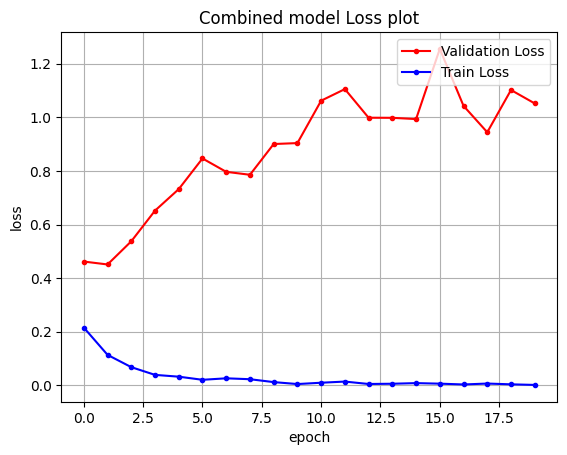

In [103]:
y_loss = combined_hist.history['loss']
y_vloss = combined_hist.history['val_loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train Loss")

plt.legend(loc='upper right')
plt.title("Combined model Loss plot")
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

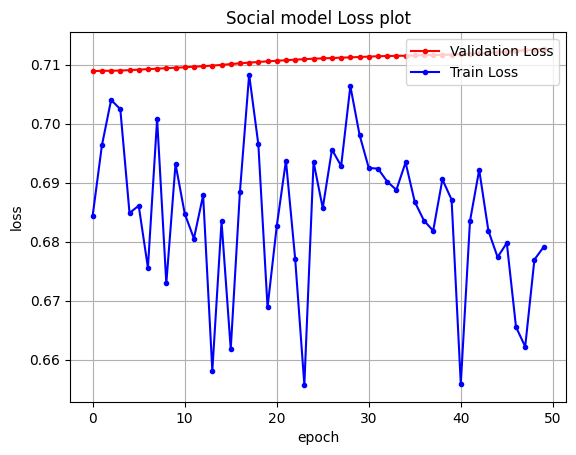

In [104]:
y_loss = social_hist.history['loss']
y_vloss = social_hist.history['val_loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train Loss")

plt.legend(loc='upper right')
plt.title("Social model Loss plot")
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

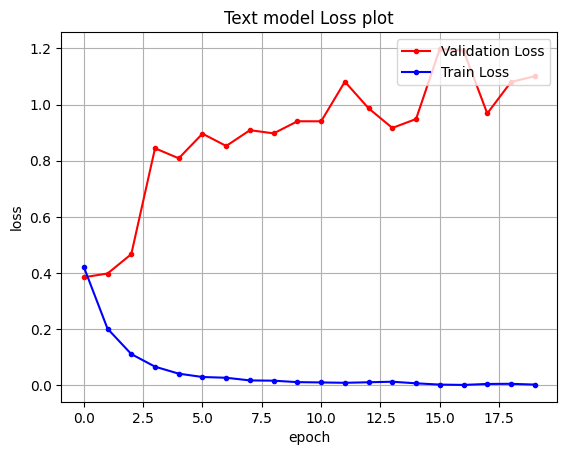

In [105]:
y_loss = text_hist.history['loss']
y_vloss = text_hist.history['val_loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train Loss")

plt.legend(loc='upper right')
plt.title("Text model Loss plot")
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

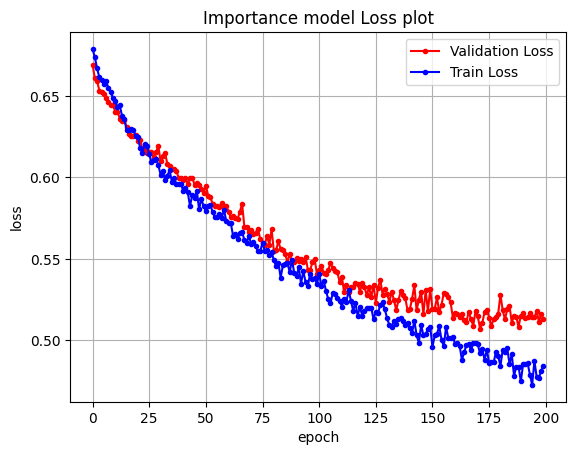

In [106]:
y_loss = importance_hist.history['loss']
y_vloss = importance_hist.history['val_loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train Loss")

plt.legend(loc='upper right')
plt.title("Importance model Loss plot")
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [107]:
social_model.load_weights('best_social.h5')
text_model.load_weights('best_text.h5')
importance_model.load_weights('best_importance.h5')
combined_model.load_weights('best_combined.h5')

In [108]:
social_model._name = "Social_model"
text_model._name = "Text_model"
importance_model._name = "Importance_model"

In [109]:
combined_model._name = "Combined_model"
combined_model.summary()

Model: "Combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 4, 5)]               0         []                            
                                                                                                  
 model_9 (Functional)        (None, 1, 64)                2784      ['input_6[0][0]']             
                                                                                                  
 input_7 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 100)]                0         []                            
                                                                                     

In [110]:
social_model.summary()

Model: "Social_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4, 5)]            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 32)             672       
                                                                 
 dropout_3 (Dropout)         (None, 1, 32)             0         
                                                                 
 dense_8 (Dense)             (None, 1, 64)             2112      
                                                                 
 dense_9 (Dense)             (None, 1, 1)              65        
                                                                 
 tf.__operators__.getitem_2  (None, 1)                 0         
  (SlicingOpLambda)                                              
                                                      

In [111]:
text_model.summary()

Model: "Text_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 128)          5120000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5169473 (19.72 MB)
Trainable params: 5169473 (19.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [112]:
importance_model.summary()

Model: "Importance_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [113]:
s_result = social_model.evaluate(social_valid_x, social_valid_y)

1/1 [==============================] - 0s 45ms/step - loss: 0.7214 - accuracy: 0.3333


1/1 [==============================] - 0s 39ms/step


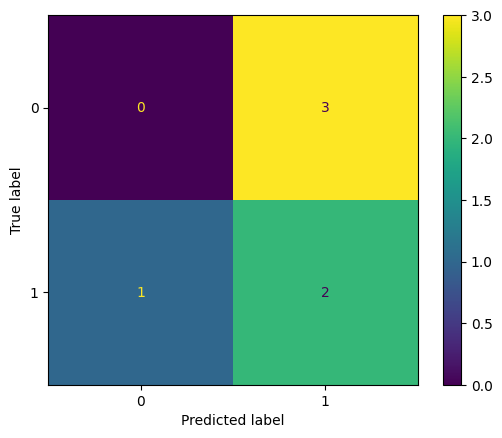

0.3333333333333333
(0.4, 0.6666666666666666, 0.5, None)


In [114]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

#Predict
y_prediction = social_model.predict(social_valid_x)

y_true = social_valid_y
y_pred = np.rint(y_prediction)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_true, y_pred)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=result,
                              display_labels=[0,1])

disp.plot()
plt.show()

print(accuracy_score(y_true, y_pred))
print(precision_recall_fscore_support(y_true, y_pred, average='binary'))

In [115]:
i_result = importance_model.evaluate(importance_valid_x, importance_valid_y)

22/22 [==============================] - 0s 3ms/step - loss: 0.7207 - accuracy: 0.7074


In [116]:
 importance_model.predict(importance_valid_x)

22/22 [==============================] - 0s 2ms/step


array([[9.70566154e-01],
       [6.19914532e-01],
       [6.81671023e-01],
       [9.77726758e-01],
       [9.83776927e-01],
       [5.80897689e-01],
       [5.95663548e-01],
       [8.74498248e-01],
       [9.02226031e-01],
       [6.19237661e-01],
       [5.71508586e-01],
       [9.47058022e-01],
       [1.77657064e-02],
       [6.94430172e-01],
       [2.10426748e-02],
       [7.96503067e-01],
       [6.48508742e-02],
       [9.39114317e-02],
       [4.45048928e-01],
       [8.57115984e-01],
       [1.14308326e-02],
       [9.44801271e-01],
       [6.04179978e-01],
       [3.12396914e-01],
       [6.00649118e-01],
       [9.43782747e-01],
       [1.73189357e-01],
       [1.31941199e-01],
       [7.05652952e-01],
       [2.00655591e-02],
       [3.93387675e-01],
       [7.79211521e-01],
       [6.46012366e-01],
       [1.81850120e-01],
       [1.43181141e-02],
       [9.21511091e-03],
       [5.89800894e-01],
       [4.56622094e-01],
       [8.44522655e-01],
       [1.52087092e-01],


22/22 [==============================] - 0s 2ms/step


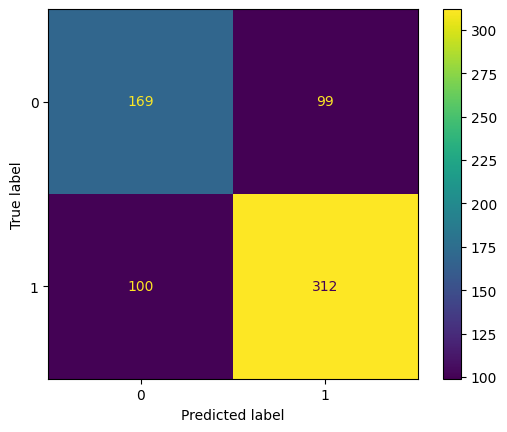

0.7073529411764706
(0.7591240875912408, 0.7572815533980582, 0.7582017010935601, None)


In [117]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

#Predict
y_prediction = importance_model.predict(importance_valid_x)

y_true = importance_valid_y
y_pred = np.rint(y_prediction)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_true, y_pred)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=result,
                              display_labels=[0,1])

disp.plot()
plt.show()

print(accuracy_score(y_true, y_pred))
print(precision_recall_fscore_support(y_true, y_pred, average='binary'))

In [118]:
t_result = text_model.evaluate(valid_padded_sequences, text_valid_y)
# print(f'텍스트 모델의 검증 데이터 결과: loss={np.round(t_result[0],3)}, accuracy={np.round(t_result[1],3)}')

201/201 [==============================] - 1s 6ms/step - loss: 0.4382 - accuracy: 0.8318


In [119]:
text_model.predict(valid_padded_sequences)

201/201 [==============================] - 1s 3ms/step


array([[0.98638713],
       [0.82006437],
       [0.9631533 ],
       ...,
       [0.04505547],
       [0.03641643],
       [0.0472946 ]], dtype=float32)

201/201 [==============================] - 1s 3ms/step


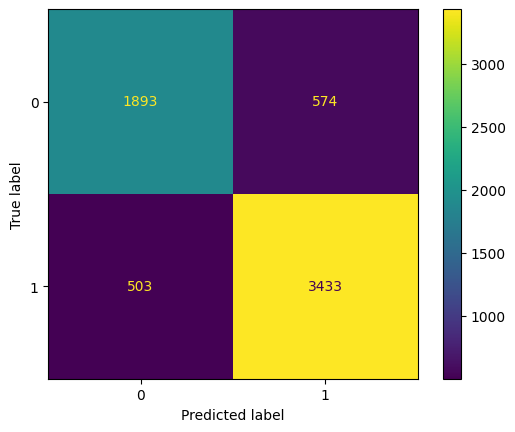

0.8317975948774012
(0.8567506862989768, 0.8722052845528455, 0.8644089135087498, None)


In [120]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

#Predict
y_prediction = text_model.predict(valid_padded_sequences)

y_true = text_valid_y
y_pred = np.rint(y_prediction)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_true, y_pred)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=result,
                              display_labels=[0,1])

disp.plot()
plt.show()

print(accuracy_score(y_true, y_pred))
print(precision_recall_fscore_support(y_true, y_pred, average='binary'))

In [121]:
c_result = combined_model.evaluate([combined_social_x_valid, combined_importance_x_valid, combined_text_x_valid], valid_df["elected"].values)
print(f'혼합 모델의 검증 데이터 결과: loss={np.round(c_result[0],3)}, accuracy={np.round(c_result[1],3)}')
# print(f'혼합 모델의 검증 데이터 결과: loss={np.round(c_result[0],3)}, accuracy={np.round(c_result[1],3)}')

201/201 [==============================] - 1s 4ms/step - loss: 0.4620 - accuracy: 0.8426
혼합 모델의 검증 데이터 결과: loss=0.462, accuracy=0.843


201/201 [==============================] - 1s 4ms/step


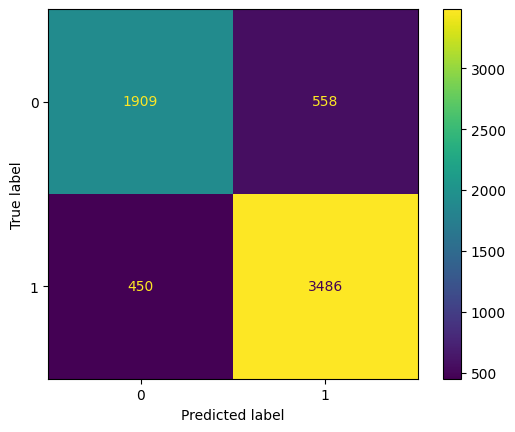

0.8425737935342809
(0.8620178041543026, 0.885670731707317, 0.8736842105263157, None)


In [122]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

#Predict
y_prediction = combined_model.predict([combined_social_x_valid, combined_importance_x_valid, combined_text_x_valid])

y_true = valid_df["elected"].values
y_pred = np.rint(y_prediction)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_true, y_pred)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=result,
                              display_labels=[0,1])

disp.plot()
plt.show()

print(accuracy_score(y_true, y_pred))
print(precision_recall_fscore_support(y_true, y_pred, average='binary'))

In [123]:
print(f'텍스트 모델의 검증 데이터 결과: loss={np.round(t_result[0],3)}, accuracy={np.round(t_result[1],3)}')
print(f'사회 지표 모델의 검증 데이터 결과: loss={np.round(s_result[0],3)}, accuracy={np.round(s_result[1],3)}')
print(f'중요도 모델의 검증 데이터 결과: loss={np.round(i_result[0],3)}, accuracy={np.round(i_result[1],3)}')
print(f'혼합 모델의 검증 데이터 결과: loss={np.round(c_result[0],3)}, accuracy={np.round(c_result[1],3)}')

텍스트 모델의 검증 데이터 결과: loss=0.438, accuracy=0.832
사회 지표 모델의 검증 데이터 결과: loss=0.721, accuracy=0.333
중요도 모델의 검증 데이터 결과: loss=0.721, accuracy=0.707
혼합 모델의 검증 데이터 결과: loss=0.462, accuracy=0.843


In [124]:
i_predict = list(zip(test_df["name"],importance_model.predict(combined_importance_x_test)))
s_predict = list(zip(test_df["name"],social_model.predict(combined_social_x_test)))
t_predict = list(zip(test_df["name"],text_model.predict(combined_text_x_test)))

c_predict = list(zip(test_df["name"],combined_model.predict([combined_social_x_test, combined_importance_x_test, combined_text_x_test])))

27/27 [==============================] - 0s 3ms/step


In [125]:
c_predict = list(zip(test_df["name"],combined_model.predict([combined_social_x_test, combined_importance_x_test, combined_text_x_test])))

idx_list = ['혼합 모델']
for idx, predict in enumerate([c_predict]):
  biden_pred = list()
  trump_pred = list()
  for pred in predict:
    if pred[0] == 'Joseph R. Biden':
      biden_pred.append(pred[1].item())
    if pred[0] == 'Donald J. Trump':
      trump_pred.append(pred[1].item())

  def softmax(x):

    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

  softmax = softmax([np.mean(biden_pred), np.mean(trump_pred)])
  print(f'{idx_list[idx]} 최종 예측: Biden이 될 확률 {np.round(softmax[0],3)}, Trump가 될 확률 {np.round(softmax[1],3)}')

27/27 [==============================] - 0s 4ms/step
혼합 모델 최종 예측: Biden이 될 확률 0.546, Trump가 될 확률 0.454


In [126]:

idx_list = ['중요도 모델', '텍스트 모델', '혼합 모델']

s_pred = list()
for pred in s_predict:
  s_pred.append(pred[1].item())
print(f'사회지표 모델 최종 예측: Trump가 될 확률 {np.round(np.mean(s_pred),3)}')

for idx, predict in enumerate([i_predict,t_predict, c_predict]):
  biden_pred = list()
  trump_pred = list()
  for pred in predict:
    if pred[0] == 'Joseph R. Biden':
      biden_pred.append(pred[1].item())
    if pred[0] == 'Donald J. Trump':
      trump_pred.append(pred[1].item())

  def softmax(x):

    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

  softmax = softmax([np.mean(biden_pred), np.mean(trump_pred)])

  # print(f'{idx_list[idx]} 최종 예측: Biden이 될 확률 {np.round(np.mean(biden_pred),3)}, Trump가 될 확률 {np.round(np.mean(trump_pred),3)}')
  print(f'{idx_list[idx]} 최종 예측: Biden이 될 확률 {np.round(softmax[0],3)}, Trump가 될 확률 {np.round(softmax[1],3)}')

사회지표 모델 최종 예측: Trump가 될 확률 0.387
중요도 모델 최종 예측: Biden이 될 확률 0.518, Trump가 될 확률 0.482
텍스트 모델 최종 예측: Biden이 될 확률 0.541, Trump가 될 확률 0.459
혼합 모델 최종 예측: Biden이 될 확률 0.546, Trump가 될 확률 0.454


In [127]:
i_predict = np.array(i_predict)
s_predict = np.array(s_predict)
t_predict = np.array(t_predict)
c_predict = np.array(c_predict)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (836, 2) + inhomogeneous part.

In [ ]:
len(combined_text_x_test)

test_df["name"].shape

In [ ]:
with open('importance_prediction.pkl','wb') as f:
  pickle.dump(list(zip(test_df["name"],importance_model.predict(combined_importance_x_test))),f)
with open('social_prediction.pkl','wb') as f:
  pickle.dump(list(zip(test_df["name"],social_model.predict(combined_social_x_test))),f)
with open('text_prediction.pkl','wb') as f:
  pickle.dump(list(zip(test_df["name"],text_model.predict(combined_text_x_test))),f)

In [ ]:
with open('combined_prediction.pkl','wb') as f:
  pickle.dump(list(zip(test_df["name"],combined_model.predict([combined_social_x_test, combined_importance_x_test, combined_text_x_test]))),f)

In [ ]:
with open('importance_hist.pkl','wb') as f:
  pickle.dump(importance_hist, f)
with open('text_hist.pkl','wb') as f:
  pickle.dump(text_hist, f)
with open('social_hist.pkl','wb') as f:
  pickle.dump(social_hist, f)
with open('combined_hist.pkl','wb') as f:
  pickle.dump(combined_hist, f)

# with open('importance_hist.pkl','wb') as f:
#   pickle.dump(importance_hist, f)
# with open('importance_hist.pkl','wb') as f:
#   pickle.dump(importance_hist, f)

In [ ]:
text_x.shape

In [ ]:
# text_timestep=100
# importance_feature=10
# social_features = 5
# dropout_p = 0.5

# def get_combined_model(use_cnn=False):

#   importance_input = keras.layers.Input(shape=(importance_feature,))
#   importance_x = keras.layers.Dense(32,activation='relu')(importance_input)
#   importance_output = keras.layers.Dense(1,activation='sigmoid')(importance_x)


#   text_input = keras.layers.Input(shape=(None, text_timestep))
#   # text_xs = list()

#   # for i in range(text_input.shape[0]):
#   #   text_xs.append(text_input[i])
#   #   text_xs[i] = text_embedding(text_xs[i])
#   #   text_xs[i] = text_lstm(text_xs[i])
#   # text_x = keras.layers.Average([text_xs])
#   # text_output = keras.layers.Dense(1, activation='sigmoid')(text_x)

#   text_input = keras.layers.Input(shape=(text_timestep,))
#   text_embedding = keras.layers.Embedding(max_vocab_size, 128, input_length=text_timestep)
#   text_x = text_embedding(text_input)
#   text_lstm = keras.layers.LSTM(64, dropout=dropout_p)
#   text_x = text_lstm(text_x)
#   text_output = keras.layers.Dense(1, activation='sigmoid')(text_x)


#   social_input = keras.layers.Input(shape=(4, social_features))
#   cnn_x = keras.layers.Conv1D(filters=64, kernel_size=kernel_size, padding='same', activation='relu')(social_input)
#   cnn_x = keras.layers.Dropout(dropout_p)(cnn_x)
#   cnn_x = keras.layers.Dense(64, activation='relu')(cnn_x)
#   cnn_output = keras.layers.Dense(1, activation='sigmoid')(cnn_x)[:,:,0]

#   lstm_x = keras.layers.LSTM(64, dropout=dropout_p)(social_input)
#   lstm_output = keras.layers.Dense(1, activation='sigmoid')(lstm_x)

#   social_x = cnn_x if use_cnn else lstm_x
#   social_output = cnn_output if use_cnn else lstm_output

#   ensemble_output = keras.layers.Dense(1, activation='sigmoid')(keras.layers.concatenate([importance_output, text_output, social_output]))

#   return keras.Model(inputs=[importance_input, text_input, social_input], outputs=[importance_output, text_output, social_output, ensemble_output])

In [ ]:
# train social model using social data
# train text model using text data
# train importance model using importance data

# test with a dataset that has social, text, importance

# ensemble the results of the 3 models

# models =